In [249]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector, Reshape, Flatten
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import keras.backend as K
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [245]:
data = ['Dataset/HandOutlines_TRAIN', 'Dataset/HandOutlines_TEST']
full_train_data = pd.read_csv(data[0], header = None)
full_test_data = pd.read_csv(data[1], header = None)

train_dataset = full_train_data.iloc[:,range(1,full_train_data.shape[1])] #traindatawithoutlabel
label_train = full_train_data.iloc[:,0] #trainlabel

test_dataset = full_test_data.iloc[:,range(1,full_test_data.shape[1])] #testdatawithoutlabel
label_test = full_test_data.iloc[:,0] #testlabel

train_dataset = train_dataset.values
label_train = label_train.values

test_dataset=test_dataset.values
label_test=label_test.values

test_data = np.expand_dims(test_dataset, axis=2)
train_dataset = np.expand_dims(train_dataset, axis=2)



In [246]:
encoding_dim = 2
window_length = train_dataset.shape[1]
epochs = 1
test_samples = train_dataset.shape[0]

In [260]:
input_window = Input(shape=(window_length,1))
x = Conv1D(32, 7, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(3, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(7, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Flatten()(encoded)
x = Dense(32, activation='relu')(x)
# x = Dense(32, activation='relu')(encoded)
# x = Dense(32, activation='relu')(x)
x = Dense(129, activation ='relu')(x)
x = Reshape((129,1))(x)


x = Conv1D(1, 1, activation="relu", padding="same")(x) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(7)(x) # 6 dims
x = Conv1D(32, 1, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(3)(x) # 10 dims
decoded = Conv1D(1, 2, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(test_data, test_data,
                epochs=120,
                batch_size=16,
                shuffle=True,
                validation_data=(train_dataset, train_dataset))

decoded_stocks = autoencoder.predict(train_dataset)

Model: "model_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 2709, 1)           0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 2709, 32)          256       
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 903, 32)           0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 903, 1)            97        
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 129, 1)            0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 129)               0         
_________________________________________________________________
dense_114 (Dense)            (None, 32)                416

Epoch 59/120
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6647 - val_loss: 0.6642
Epoch 60/120
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6642 - val_loss: 0.6637
Epoch 61/120
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6637 - val_loss: 0.6632
Epoch 62/120
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6632 - val_loss: 0.6627
Epoch 63/120
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6627 - val_loss: 0.6622
Epoch 64/120
1000/1000 [==============================] - 7s 7ms/step - loss: 0.6622 - val_loss: 0.6618
Epoch 65/120
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6618 - val_loss: 0.6613
Epoch 66/120
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6613 - val_loss: 0.6608
Epoch 67/120
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6608 - val_loss: 0.6603
Epoch 68/120
1000/1000 [==============================] - 5s 5ms

In [236]:
x_train_deep = test_data.reshape((len(test_data), np.prod(test_data.shape[1:])))
x_test_deep = train_dataset.reshape((len(train_dataset), np.prod(train_dataset.shape[1:])))

input_window = Input(shape=(window_length,))

x = Dense(64, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
# "decoded" is the lossy reconstruction of the input

x = Dense(32, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
K.set_value(autoencoder.optimizer.learning_rate, 0.0001)
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

decoded_stocks = autoencoder.predict(x_test_deep)

Model: "model_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 152)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 64)                9792      
_________________________________________________________________
batch_normalization_47 (Batc (None, 64)                256       
_________________________________________________________________
dense_94 (Dense)             (None, 2)                 130       
_________________________________________________________________
dense_95 (Dense)             (None, 32)                96        
_________________________________________________________________
batch_normalization_48 (Batc (None, 32)                128       
_________________________________________________________________
dense_96 (Dense)             (None, 152)               501

Get reproduction error
GunPoint : 0.48691671698691363

In [237]:
print(decoded_stocks.shape,x_test_deep.shape)
# print(np.absolute(x_test_deep[0]))
# print(np.absolute(decoded_stocks[0]))
# print(len(x_test_deep[0]))
def repr_error(actual, predicted):
    final_err = 0
    for i in range(len(actual)):
        err = np.sum(np.absolute(np.absolute(actual[i]) - np.absolute(predicted[i])))
        err = err / len(actual[i])
        final_err += err
    final_err = final_err / len(actual)
    return final_err
# final_test = np.sum(np.absolute(np.absolute(x_test_deep[0]) - np.absolute(decoded_stocks[0])))
# print(final_test/150)
print(repr_error(x_test_deep, decoded_stocks))

(1000, 152) (1000, 152)
0.5007489203762054


In [ ]:
import pickle
# open a file, where you ant to store the data
file = open('Deep_forda.pkl', 'wb')

# dump information to that file
pickle.dump(autoencoder, file)

Get embedding values for test data

In [238]:
autoencoder.layers[3].name = "embed_0"
layer_output=autoencoder.get_layer('embed_0').output
intermediate_model=Model(inputs=autoencoder.input,outputs=layer_output)
normal_test=intermediate_model.predict(x_test_deep)
normal_train=intermediate_model.predict(x_train_deep)
print(normal_test.shape,normal_train.shape)

(1000, 2) (6164, 2)


In [ ]:
file = open('Embed_forda.pkl', 'wb')

nor_info = {}
nor_info['X_train'] = normal_train
nor_info['y_train'] = label_test
nor_info['X_test'] = normal_test
nor_info['y_test'] = label_train

# dump information to that file
pickle.dump(nor_info, file)

In [22]:
# normal_test[1]
# dot1 = normal_test[1][normal_test[1] != 0] #0
# dot2 = normal_test[2][normal_test[2] != 0] #1
dot1_y = normal_test[1]
dot2_y = normal_test[2]
dot1_x = list(range(encoding_dim))
dot2_x = list(range(encoding_dim))
# print(dot1_y)
for i in range(encoding_dim):
    if dot1_y[i] == 0:
        dot1_x.remove(i)
#         dot1_y = np.delete(dot1_y,i,0)
    if dot2_y[i] == 0:
        dot2_x.remove(i)
#         dot2_y = np.delete(dot2_y,i,0)
dot1_y = normal_test[1][normal_test[1] != 0] #0
dot2_y = normal_test[2][normal_test[2] != 0] #1
x,y=[], []
x.append(dot1_x)
x.append(dot2_x)
y.append(dot1_y)
y.append(dot2_y)

# print(len(dot1),len(dot2))
# label_train
len(label_test)

150

In [241]:
dat = []
fin_label = []
count1, count2 = 150, 150
for i in range(len(label_train)):
    if normal_test[i][0] != 0 and normal_test[i][1] != 0:
        if(label_train[i] == 1 and count1 > 0):
            dat.append([normal_test[i][0],normal_test[i][0]])
            fin_label.append(1)
            count1-=1
        if(label_train[i] == -1 and count2 > 0):
            dat.append([normal_test[i][0],normal_test[i][0]])
            fin_label.append(0)
            count2-=1
            
# for i in range(len(label_train)):
#     if normal_test[i][0] != 0 and normal_test[i][1] != 0:
# #         if(label_train[i] == 1 and count1 > 0):
#         dat.append([normal_test[i][0],normal_test[i][0]])
#         fin_label.append(label_train[i])
# #             count1-=1
# #         if(label_train[i] == 0 and count2 > 0):
# #             dat.append([normal_test[i][0],normal_test[i][0]])
# #             fin_label.append(0)
# #             count2-=1
            
for i in range(len(label_test)):
    if normal_train[i][0] != 0 and normal_train[i][1] != 0:
        if(label_test[i] == 1 and count1 > 0):
            dat.append([normal_train[i][0],normal_train[i][0]])
            fin_label.append(1)
            count1-=1
        if(label_test[i] == -1 and count2 > 0):
            dat.append([normal_train[i][0],normal_train[i][0]])
            fin_label.append(0)
            count2-=1
dat = np.array(dat)
count = fin_label.count(0)
fin_label = np.array(fin_label)
# data, label = [], []
dat
# label_test
count

# print(data,labels)

150

In [188]:
import umap
import umap.plot

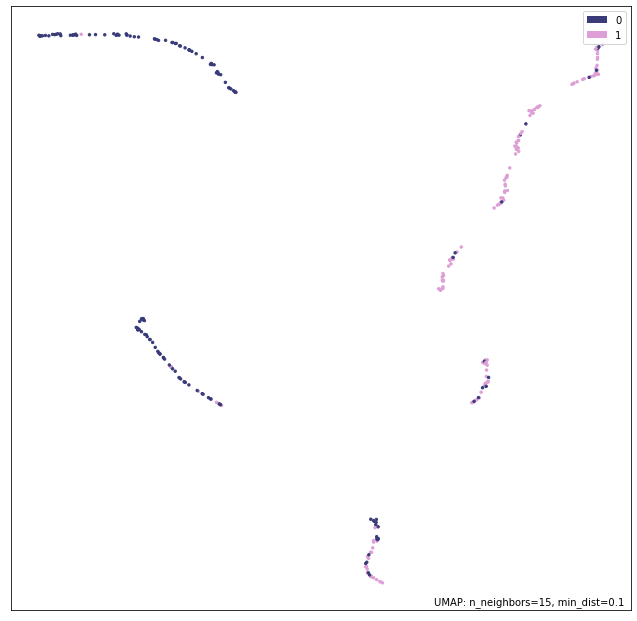

In [243]:
mapper = umap.UMAP().fit(dat)
umap.plot.points(mapper, labels = fin_label, theme='red')

TypeError: Tensor objects are only iterable when eager execution is enabled. To iterate over this tensor use tf.map_fn.

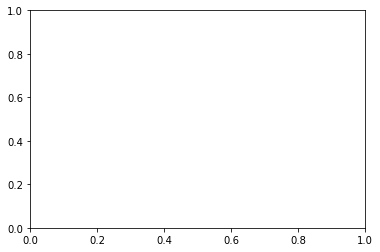

In [186]:
import matplotlib.pyplot as plt
# plt.rcParams['figure.facecolor'] = 'white'
fig, ax = plt.subplots()
# fig.patch.set_facecolor('white')
i=0
for color in ['black', 'blue']:
    n = 750
    x1, y1 = x[i],y[i]
    
#     scale = 200.0 * np.random.rand(n)
    ax.scatter(x1, y1, c=color,  label='Class: '+str(i),
               alpha=0.3, edgecolors='none')
    i+=1

ax.legend()
ax.get_xaxis().set_visible(False)

# ax.grid(True)

plt.show()

In [90]:
import seaborn as sns; #sns.set()
# sns.set_style("dark")

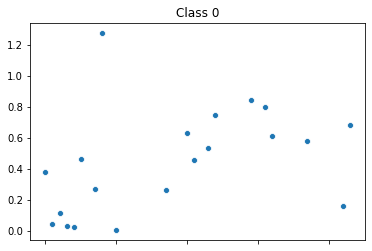

In [91]:
ax = sns.scatterplot(x=dot1_x, y=dot1_y)
ax.set(xticklabels=[])
ax.set(xlabel=None)
ax.set_title('Class 0')
plt.show()

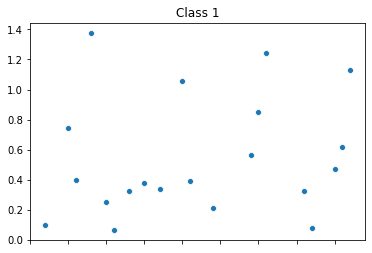

In [92]:
ax = sns.scatterplot(x=dot2_x, y=dot2_y)
ax.set(xticklabels=[])
ax.set(xlabel=None)
ax.set_title('Class 1')
plt.show()

In [ ]:
print(x_test_deep[10].shape)
plt.plot(x_test_deep[0])
plt.show()

In [ ]:
print(decoded_stocks[10].shape)
# print(decoded_stocks[0])
plt.plot(decoded_stocks[0])
plt.show()